In [15]:
install.packages("caret", dependencies=TRUE, type="win.binary")
install.packages("partykit", dependencies=TRUE, type="win.binary")

Installing package into 'C:/Users/sualp.say/Documents/R/win-library/3.6'
(as 'lib' is unspecified)




  There is a binary version available (and will be installed) but the
  source version is later:
      binary source
caret 6.0-86 6.0-90



Warning message:
"package 'caret' is in use and will not be installed"
Installing package into 'C:/Users/sualp.say/Documents/R/win-library/3.6'
(as 'lib' is unspecified)




  There is a binary version available (and will be installed) but the
  source version is later:
         binary source
partykit 1.2-13 1.2-15



also installing the dependencies 'RWekajars', 'inum', 'pmml', 'vcd', 'AER', 'RWeka', 'psychotools', 'psychotree'




package 'RWekajars' successfully unpacked and MD5 sums checked
package 'inum' successfully unpacked and MD5 sums checked
package 'pmml' successfully unpacked and MD5 sums checked
package 'vcd' successfully unpacked and MD5 sums checked
package 'AER' successfully unpacked and MD5 sums checked
package 'RWeka' successfully unpacked and MD5 sums checked
package 'psychotools' successfully unpacked and MD5 sums checked
package 'psychotree' successfully unpacked and MD5 sums checked
package 'partykit' successfully unpacked and MD5 sums checked

The downloaded binary packages are in
	C:\Users\sualp.say\AppData\Local\Temp\RtmpSmxd8o\downloaded_packages


In [1]:
library(data.table)
library(repr)
library(lubridate)
library(partykit)
library(rpart)
library(ggplot2)
library(TSdist)
library(dtw)
library(TSrepr)
library(TunePareto)
library(caret)

options(repr.plot.width=15, repr.plot.height=8)

Warning message:
"package 'data.table' was built under R version 3.6.3"
Warning message:
"package 'lubridate' was built under R version 3.6.3"

Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union


Warning message:
"package 'partykit' was built under R version 3.6.3"
Loading required package: grid

Loading required package: libcoin

Warning message:
"package 'libcoin' was built under R version 3.6.3"
Loading required package: mvtnorm

Warning message:
"package 'mvtnorm' was built under R version 3.6.3"
Warning message:
"package 'rpart' was built under R version 3.6.3"
Registered S3 methods overwritten by 'tibble':
  method     from  
  format.tbl pillar
  print.tbl  pillar

Warning message:
"package 'TSdist' was built under R version 3.6.3"
Loading required package: prox

In [44]:
current_folder = getwd()
dat = fread('bulk_imbalance.csv')
dat = dat[!(date==max(dat$date))]

In [45]:
buffer_zone_start = 5
window_size = 36 

copy_dat = copy(dat)

# lag the hours according to window_size to create a matrix
preprocessed_data = copy_dat[, paste0((buffer_zone_start+1):(buffer_zone_start+window_size), "_hours_before") := shift(net, (buffer_zone_start+1):(buffer_zone_start+window_size))]

# remove the rows having NA lags values due to time boundry of the data and select only the complete_cases
preprocessed_data = preprocessed_data[complete.cases(preprocessed_data), ]

In [13]:
dat17 = preprocessed_data[hour==17]
dat17[, id:=1:.N]

dat17_sample = dat17[,.SD[sample(.N, min(3,.N))], by = system_direction]
dat17_sample[, class:=system_direction]

In [46]:
dat_plot = copy(preprocessed_data)
dat_plot[, id:=.GRP, by=c("date", "hour")]

dat_plot_sample = dat_plot[,.SD[sample(.N, min(3,.N))], by = c("hour", "system_direction")]
dat_plot_sample[, class:=system_direction]
dat_plot_sample[, target:=hour]

In [50]:
dat_plot_sample[hour==17][,14]

7_hours_before
1  -702.545     
2  -128.251     
3  -245.780     
4 -1356.454     
5  -543.924     
6  1575.382     
7   795.001     
8    21.592     
9  1040.249

In [53]:
long = melt(dat_plot_sample[,13:ncol(dat_plot_sample)], id.vars=c("target",'id','class'))
long[,time:=as.numeric(gsub("\\D", "", variable))-5]
long=long[,list(target,id,class,time,value)]
long=long[order(target,id,time)]

# check
head(long)

target id  class    time value   
1 0      608 Negative 1     -54.000
2 0      608 Negative 2    -460.401
3 0      608 Negative 3    -190.055
4 0      608 Negative 4     280.467
5 0      608 Negative 5     158.384
6 0      608 Negative 6     401.800

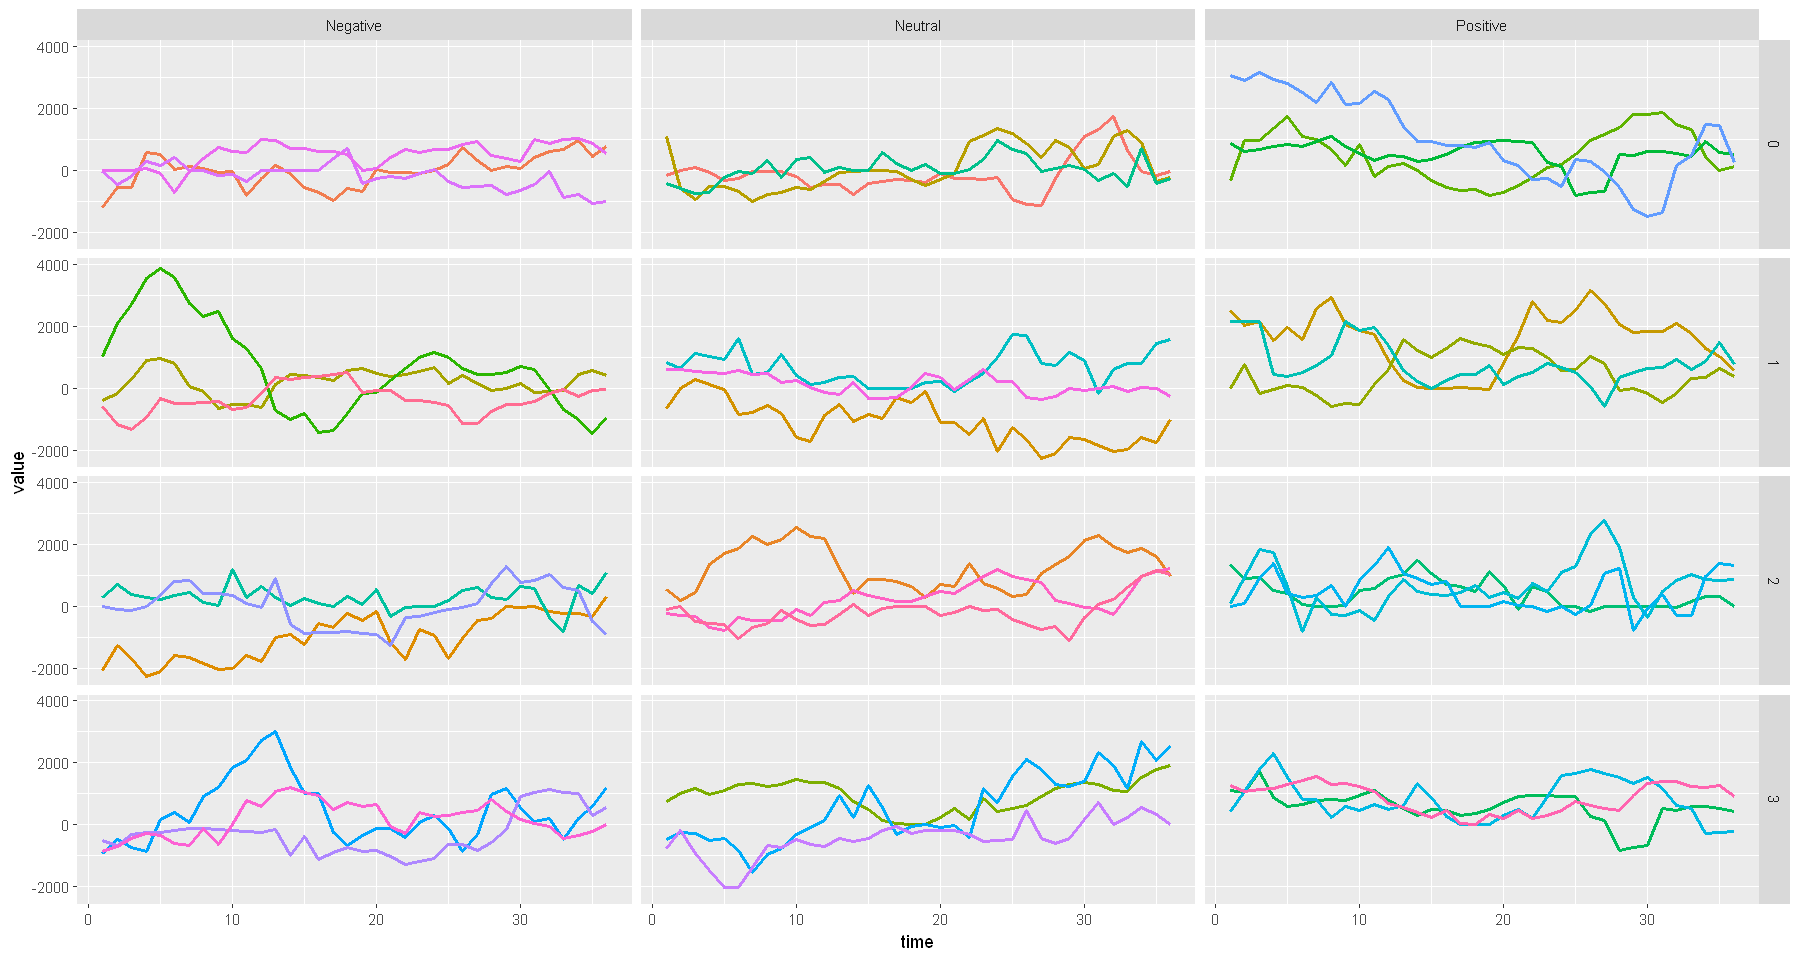

In [73]:
ggplot(long[target %in% (0:3)], aes(time,value)) + geom_line(aes(color=as.character(id)), size=1, show.legend=FALSE) + facet_grid(target~class)

In [ ]:
# kNN with caret package

In [3]:
dat[,diff:=dat$net - shift(dat$net, 1)]

In [ ]:
dat[,t:=1:.N]
fit_lm_tree = lmtree(net~t | t, dat)
pred_lmtree <- predict(fit_lm_tree, dat)
dat$lmtree <- pred_lmtree

In [3]:
series <- list()
start_hours_before <- 6
window_sizes <- c(12,24,36)
dat$raw <- dat$net
cols <- c("raw")
raw_names <- character(0)
hour_window <- character(0)
for(c in cols){
    for(w in window_sizes){
        tmp <- data.table(dat)
        tmp[, paste0((start_hours_before):(w+start_hours_before-1), "_hours_before") := shift(tmp[[c]], (start_hours_before):(w+start_hours_before-1))]
        tmp <- tmp[complete.cases(tmp),]
        for(h in 12:23){
           hour <- paste("hour",as.character(h),sep="")
           window <- paste("window",as.character(w),sep="")
           st <- which(colnames(tmp)==paste(start_hours_before,"hours_before",sep="_"))
           e <- length(colnames(tmp))
           dir <- which(colnames(tmp)=="system_direction") 
           indices <- c(1,dir,st:e)
           series[[paste(hour,window,c,sep="_")]]  <- tmp[hour==h,..indices]
           if(c=="raw"){
               raw_names <- c(raw_names,paste(hour,window,c,sep="_"))
               hour_window <- c(hour_window,paste(hour,window,sep="_"))
           } 
        }
    }
}

In [4]:
for(i in 1:length(raw_names)){
  series_long <- melt(series[[raw_names[i]]],id.vars = c("date", "system_direction"))
  long_dt <- data.table()
  for(d in unique(series_long$date)){
    temp_dt <- series_long[date==d,]
    temp_tree <- rpart(value~variable, temp_dt, minbucket=1, minsplit=2)
    temp_pred <- predict(temp_tree)
    temp_dt$tree <- temp_pred
    temp_dt[,t:=1:.N]
    temp_sax <- repr_sax(temp_dt$value, q = 2, a = 4)
    dummy_time=c(1:(length(temp_sax)-1))*2
    dummy_time=c(dummy_time,nrow(temp_dt))  
    dt_sax=data.table(t=dummy_time,sax_rep_char=temp_sax)
    temp_dt <- merge(temp_dt,dt_sax,by="t",all.x=T)
    temp_dt[,sax_rep_char_num:=nafill(as.numeric(as.factor(sax_rep_char)),'nocb')] # from data.table  
    temp_dt[,sax_rep:=mean(value),by=list(sax_rep_char_num)]  
    long_dt <- rbind(long_dt,temp_dt)
  }
  series[[paste(hour_window[i],"tree",sep="_")]] <- dcast(long_dt,date+system_direction~variable,value.var="tree")
  series[[paste(hour_window[i],"sax",sep="_")]] <- dcast(long_dt,date+system_direction~variable,value.var="sax_rep")  
}

In [74]:
raw_names

[1] "hour12_window12_raw" "hour13_window12_raw" "hour14_window12_raw"
 [4] "hour15_window12_raw" "hour16_window12_raw" "hour17_window12_raw"
 [7] "hour18_window12_raw" "hour19_window12_raw" "hour20_window12_raw"
[10] "hour21_window12_raw" "hour22_window12_raw" "hour23_window12_raw"
[13] "hour12_window24_raw" "hour13_window24_raw" "hour14_window24_raw"
[16] "hour15_window24_raw" "hour16_window24_raw" "hour17_window24_raw"
[19] "hour18_window24_raw" "hour19_window24_raw" "hour20_window24_raw"
[22] "hour21_window24_raw" "hour22_window24_raw" "hour23_window24_raw"
[25] "hour12_window36_raw" "hour13_window36_raw" "hour14_window36_raw"
[28] "hour15_window36_raw" "hour16_window36_raw" "hour17_window36_raw"
[31] "hour18_window36_raw" "hour19_window36_raw" "hour20_window36_raw"
[34] "hour21_window36_raw" "hour22_window36_raw" "hour23_window36_raw"

In [83]:
series_reduced = series[c("hour12_window12_raw",'hour12_window24_raw','hour12_window36_raw',
                          "hour13_window12_raw",'hour13_window24_raw','hour13_window36_raw') ]

In [85]:
distances <- list()
for(n in names(series_reduced)){
 
    distances[[paste(n,"euc",sep="_")]] <- as.matrix(dist(series[[n]][,3:length(series[[n]])]))
    diag(distances[[paste(n,"euc",sep="_")]]) <- 100000
    
}

In [87]:
series_reduced

$hour12_window12_raw
            date system_direction 6_hours_before 7_hours_before 8_hours_before
   1: 2019-01-02         Negative      -2085.123      -1530.308      -1335.806
   2: 2019-01-03         Negative      -1030.839      -1036.593       -777.777
   3: 2019-01-04         Negative      -1007.494       -646.096       -872.202
   4: 2019-01-05         Negative      -1520.576      -1276.306       -887.259
   5: 2019-01-06         Positive          0.000          0.000          0.000
  ---                                                                         
1099: 2022-01-04         Positive        994.564       -262.042       -653.374
1100: 2022-01-05         Negative       -695.594      -1360.665      -1105.977
1101: 2022-01-06         Positive       1400.726        911.857        922.348
1102: 2022-01-07         Positive       1463.803       1481.241       1246.872
1103: 2022-01-08         Positive        847.623        743.433        889.900
      9_hours_before 10_hours_before 11_hours_before 12_hours_before
   1:      -1191.881       -1454.050       -1537.697       -1342.151
   2:       -941.087        -675.690        -795.365       -1590.698
   3:       -886.990        -807.703        -949.636       -1786.145
   4:      -1212.783       -1155.505       -1226.037       -1726.220
   5:       -160.233          84.000          76.316        -518.325
  ---                                                               
1099:       -333.570        -128.330        -113.716        -415.500
1100:       -750.038        -978.297       -1289.013       -1506.356
1101:        795.725         800.313         742.799         881.823
1102:       1220.126        1415.022        1383.797         852.573
1103:        988.392         786.420         436.168         277.029
      13_hours_before 14_hours_before 15_hours_before 16_hours_before
   1:         249.887        -510.932        -959.578        -476.264
   2:       -1102.993        -935.940       -1128.817       -1393.381
   3:        -465.180        -799.049       -1094.551        -788.130
   4:       -1737.365       -1692.954       -1362.676       -1609.803
   5:        -570.966        -834.626        -776.519        -646.249
  ---                                                                
1099:          84.763         306.073        -120.550        -871.000
1100:       -1109.880        -515.697        -927.637        -463.126
1101:         303.143         164.834        -284.884        -264.804
1102:        2122.166        2231.059        2756.828        2381.624
1103:        1329.459        -412.343         516.102         652.159
      17_hours_before
   1:          26.246
   2:       -1056.765
   3:        -341.262
   4:       -1667.606
   5:        -877.067
  ---                
1099:        -323.970
1100:        -728.105
1101:        -533.147
1102:        2920.441
1103:        1236.677

$hour12_window24_raw
            date system_direction 6_hours_before 7_hours_before 8_hours_before
   1: 2019-01-02         Negative      -2085.123      -1530.308      -1335.806
   2: 2019-01-03         Negative      -1030.839      -1036.593       -777.777
   3: 2019-01-04         Negative      -1007.494       -646.096       -872.202
   4: 2019-01-05         Negative      -1520.576      -1276.306       -887.259
   5: 2019-01-06         Positive          0.000          0.000          0.000
  ---                                                                         
1099: 2022-01-04         Positive        994.564       -262.042       -653.374
1100: 2022-01-05         Negative       -695.594      -1360.665      -1105.977
1101: 2022-01-06         Positive       1400.726        911.857        922.348
1102: 2022-01-07         Positive       1463.803       1481.241       1246.872
1103: 2022-01-08         Positive        847.623        743.433        889.900
      9_hours_before 10_hours_before 11_hours_before 12_hours_before
   1:      -1191.881       -1454.050       -1537.697       -

In [86]:
distances

$hour12_window12_raw_euc
              1           2          3          4           5          6
1    100000.000   2646.0942   2014.097   3252.924   4104.2098   4626.894
2      2646.094 100000.0000   1244.706   1505.766   2616.6187   4609.719
3      2014.097   1244.7064 100000.000   2427.239   2568.5197   3800.715
4      3252.924   1505.7656   2427.239 100000.000   3810.7593   5904.152
5      4104.210   2616.6187   2568.520   3810.759 100000.0000   3247.694
6      4626.894   4609.7186   3800.715   5904.152   3247.6939 100000.000
7      4283.306   4076.0173   3377.644   5392.884   2465.6219   1828.057
8      4620.763   3997.0963   3346.568   5311.489   2418.0537   1488.120
9      2323.878   2392.2027   2276.492   3070.431   3340.2996   4242.501
10     2593.277   1734.1409   1741.143   2851.036   2610.0040   4047.582
11     4076.340   3417.7524   2969.313   4725.921   1448.1624   2162.555
12     4216.770   2941.0183   2681.075   4242.016   1055.0992   2588.404
13     2055.966   2204.3311   1420.608   3375.985   2596.7246   2941.489
14     3657.657   2455.2172   2049.091   3629.332   1679.7075   2777.659
15     1935.592   1094.4887   1313.872   1695.603   3063.8765   4586.311
16     3261.126   2933.6169   2423.507   4169.877   2293.4723   2396.757
17     3508.686   2418.3986   2195.801   3645.340   1312.2035   3521.331
18     4863.693   3661.5875   3419.943   4913.249   1604.5655   2579.212
19     4428.756   4246.5612   3713.666   5552.283   2597.6341   1845.951
20     3323.696   1958.2907   2061.111   2963.936   1284.6076   3767.884
21     2372.500   1061.9949   1198.729   1914.294   2500.4651   4147.214
22     2171.583   2033.1513   2207.607   2316.805   3727.0384   5038.193
23     3576.523   1928.2910   1785.892   3146.106   1670.1842   3495.971
24     4269.821   4585.5856   3892.930   5916.322   3309.1840   2268.743
25     3485.403   1901.2162   2253.537   2778.129   2024.6408   4453.809
26     4478.628   3624.0157   3261.617   4963.158   1529.3348   2472.435
27     4556.577   4005.0265   3507.013   5324.570   2078.4455   2172.916
28     3627.032   1713.8254   2526.324   2078.929   2785.1184   5538.858
29     2879.227   1789.8595   1640.412   3094.971   1512.1418   3593.503
30     4699.596   4178.1212   3705.020   5442.930   2261.0958   2501.945
31     4918.139   4359.5445   3980.834   5644.434   2288.2167   3112.781
32     5305.870   4991.2868   4503.268   6248.913   2970.6756   2649.264
33     3249.323   2989.8231   2425.272   4327.458   1959.0927   2252.936
34     5525.665   5704.8392   4960.394   7023.444   4184.1893   1867.706
35     4284.794   4075.0025   3422.899   5368.783   2707.7922   1220.663
36     3278.033   3462.1122   2743.823   4722.261   2863.0538   2283.178
37     3717.170   3446.9683   2755.719   4795.072   2101.6124   1608.445
38     5140.848   5188.1212   4454.928   6529.127   3505.0430   1387.121
39     3472.573   2673.7352   2442.736   3917.706   1426.0085   3183.101
40     7425.841   7000.7285   6664.191   8278.697   4739.2281   4224.647
41     3810.793   4287.2719   3630.872   5579.307   3293.0906   2626.354
42     4841.122   4475.2898   3930.846   5778.475   2478.9024   2171.224
43     4641.322   4867.8655   4267.000   6179.893   3389.3691   2424.427
44     5372.002   6046.0450   5284.999   7364.815   4718.1303   2613.150
45     7013.869   6434.9688   5964.284   7761.213   4039.7366   3479.587
46     6027.304   5396.5638   5078.189   6723.742   3148.6218   3140.857
47     6571.020   6563.1397   5972.621   7895.765   4621.2107   2830.541
48     6903.983   6529.4362   5976.351   7792.262   4243.8518   3191.192
49     3057.608   1809.4943   1461.385   3113.997   1288.7051   3123.755
50     6342.526   5874.0865   5487.458   7107.393   3617.2130   3431.318
51     6606.669   6959.4823   6283.030   8230.734   5171.6553   3325.021
52     6270.542   6282.5960   5655.042   7634.562   4365.8361   2567.806
53     3862.317   3825.6164   3057.677   5052.607   2924.6514   1372.650
54     6144.465   5576.8808   508

In [111]:
trainclass = series_reduced$hour12_window12_raw$system_direction
traindata = as.matrix(distances$hour12_window12_raw_euc)
traindata = data.table(cl=trainclass, traindata)

In [112]:
head(traindata)

cl       1          2          3          4          5          6         
1 Negative 100000.000   2646.094   2014.097   3252.924   4104.210   4626.894
2 Negative   2646.094 100000.000   1244.706   1505.766   2616.619   4609.719
3 Negative   2014.097   1244.706 100000.000   2427.239   2568.520   3800.715
4 Negative   3252.924   1505.766   2427.239 100000.000   3810.759   5904.152
5 Positive   4104.210   2616.619   2568.520   3810.759 100000.000   3247.694
6 Positive   4626.894   4609.719   3800.715   5904.152   3247.694 100000.000
  7        8        9        ... 1094     1095     1096     1097     1098    
1 4283.306 4620.763 2323.878 ... 3595.334 5839.787 4095.592 3327.123 4991.322
2 4076.017 3997.096 2392.203 ... 2991.703 4712.552 2301.738 2376.646 4398.766
3 3377.644 3346.568 2276.492 ... 2601.491 4845.325 2661.545 1957.553 3990.411
4 5392.884 5311.489 3070.431 ... 3440.343 5742.246 2928.635 3114.241 5766.283
5 2465.622 2418.054 3340.300 ... 3562.870 2920.699 2884.198 2929.313 2454.102
6 1828.057 1488.120 4242.501 ... 4155.775 5017.708 5279.443 3628.312 2221.310
  1099     1100     1101     1102      1103    
1 4314.686 2223.059 6608.053  9854.711 6411.486
2 3465.820 1376.414 5632.300 10100.533 6219.714
3 3166.772 1297.274 5415.942  9397.160 5589.408
4 4837.668 2280.318 6856.163 11458.577 7507.642
5 2030.871 2888.914 3121.584  8116.796 4031.436
6 2638.327 4168.077 3676.129  5925.465 2926.442

In [113]:
n_repeats=5
n_folds=10

ctrl = trainControl(method = "repeatedcv",
                    number = n_folds,
                    repeats = n_repeats)

knnFit_raw = train(cl~., data=traindata, method="knn", trControl = ctrl, tuneLength = 10)

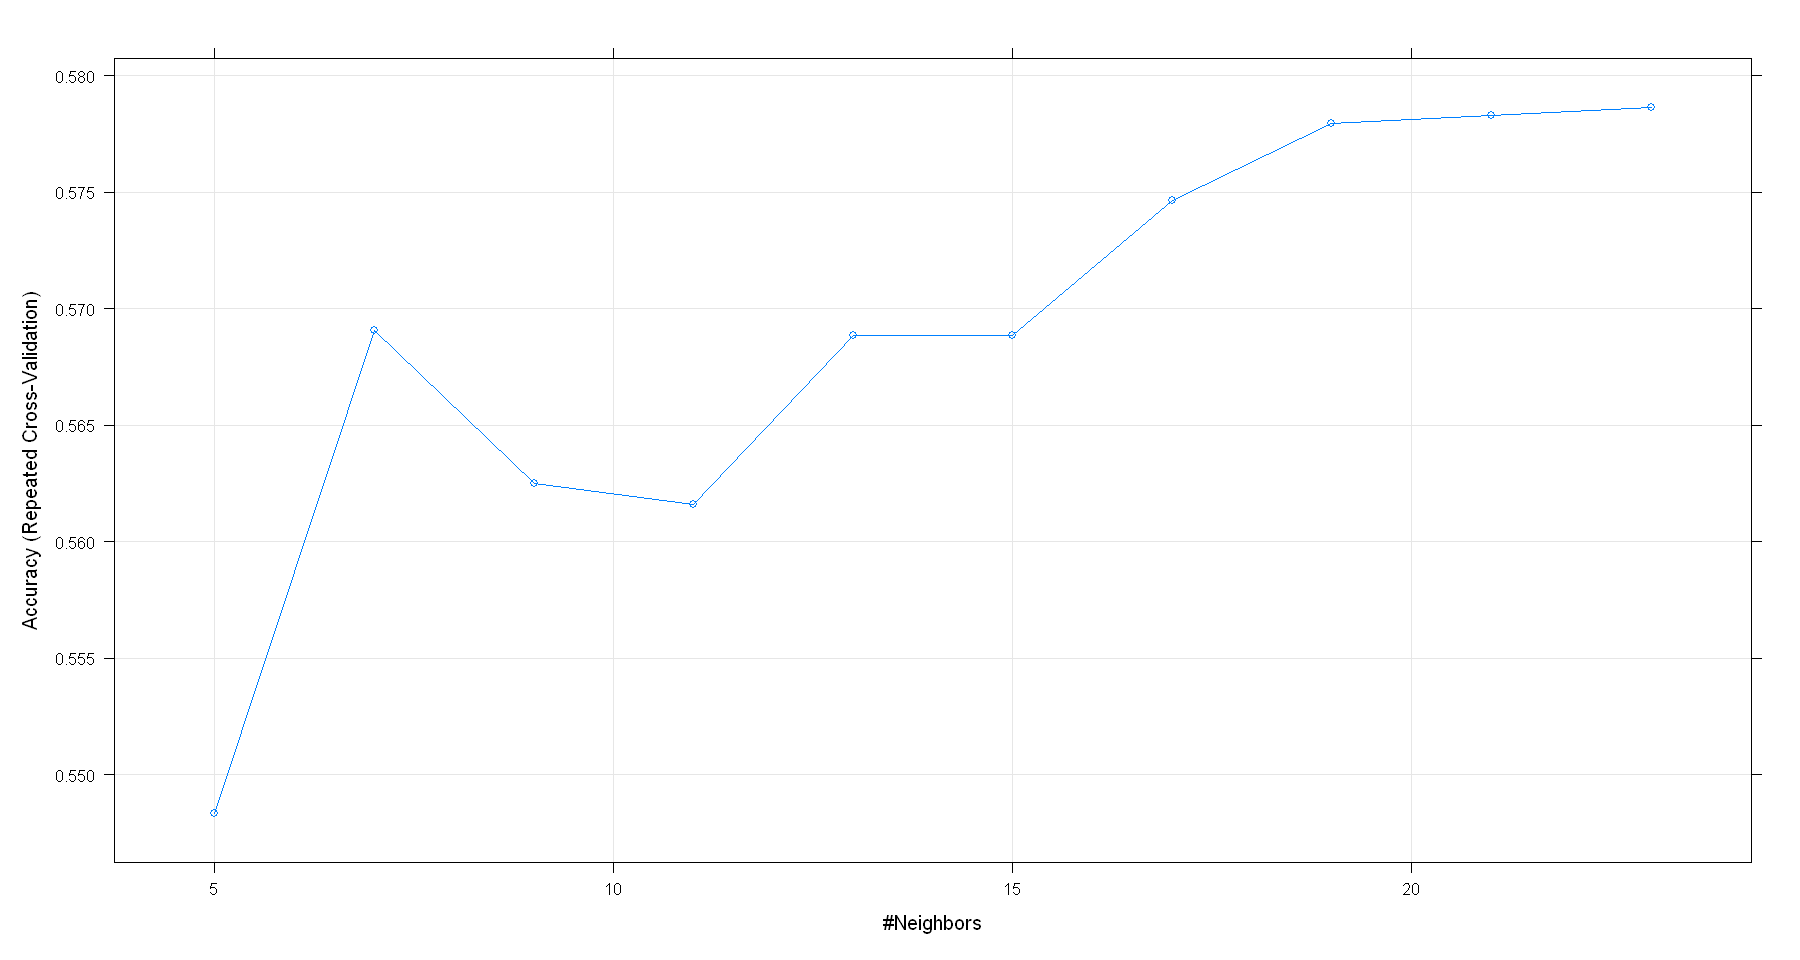

In [114]:
plot(knnFit_raw)

In [115]:
results = resamples(list(raw=knnFit_raw))
summary(results)
bwplot(results)

ERROR: Error in resamples.default(list(raw = knnFit_raw)): at least two train objects are needed
